# Group PSTH Quick Plot

This notebook demonstrates the use of the `plot.group_psth` function to plot a group PSTH.

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
%pylab --no-import-all
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
import datajoint as dj

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
from pipeline import psth
from pipeline import plot

Connecting chris@db:3306


## Group Selection Conditions

In [4]:
psth.UnitGroupCondition()

condition_id,unit_group_condition_id,unit_group_condition_desc,brain_area,selectivity_criteria_id
0,0,audio delay contra hit - global selectivity; ALM,ALM,273
1,1,audio delay ipsi hit - global selectivity; ALM,ALM,273
2,2,audio delay contra miss - global selectivity; ALM,ALM,273
3,3,audio delay ipsi miss - global selectivity; ALM,ALM,273


## Group Plots

In [5]:
contra_hit_gcond_key = (psth.UnitGroupCondition()
                        & {'unit_group_condition_id': 0}).fetch1('KEY')

ipsi_hit_gcond_key = (psth.UnitGroupCondition()
                      & {'unit_group_condition_id': 1}).fetch1('KEY')

contra_miss_gcond_key = (psth.UnitGroupCondition()
                      & {'unit_group_condition_id': 2}).fetch1('KEY')

ipsi_miss_gcond_key = (psth.UnitGroupCondition()
                      & {'unit_group_condition_id': 3}).fetch1('KEY')

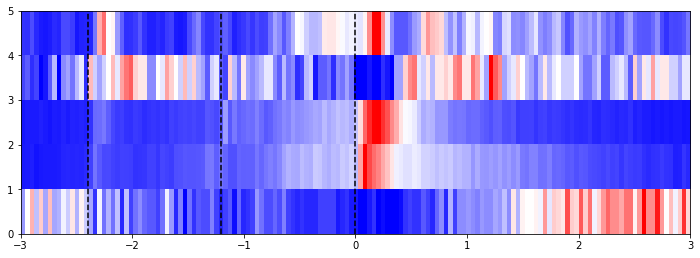

In [6]:
plot.group_psth(contra_hit_gcond_key)

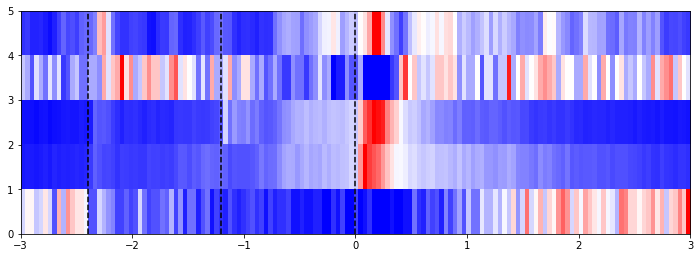

In [7]:
plot.group_psth(ipsi_hit_gcond_key)

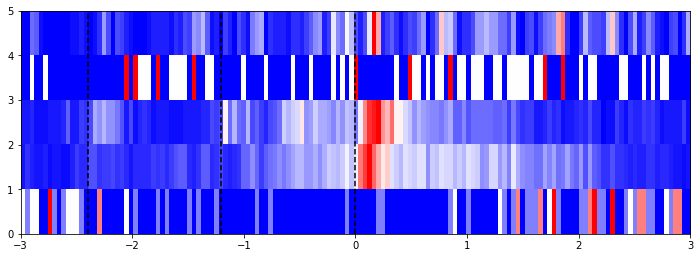

In [8]:
plot.group_psth(contra_miss_gcond_key)

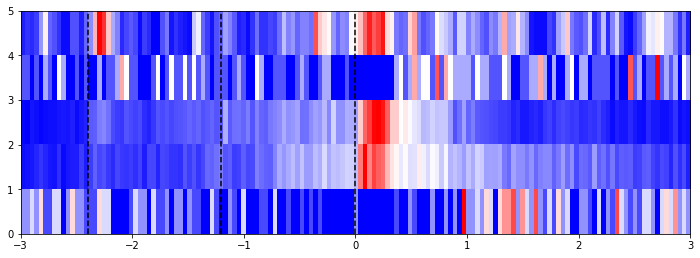

In [9]:
plot.group_psth(ipsi_miss_gcond_key)

## Per-Unit Inspection

In [10]:
psth.UnitPsth.Unit & (psth.UnitGroupPsth.Unit & ipsi_hit_gcond_key).proj()

condition_id,subject_id institution 6 digit animal ID,session session number,electrode_group Electrode_group is like the probe,unit,unit_psth
1,435884,1,1,4,=BLOB=
1,435884,1,1,63,=BLOB=
1,435884,1,1,66,=BLOB=
1,435884,1,1,91,=BLOB=
1,435884,1,1,165,=BLOB=


In [11]:
ipsi_hit_psth_units = (psth.UnitPsth.Unit 
                       & (psth.UnitGroupPsth.Unit & ipsi_hit_gcond_key).proj()).fetch('KEY')

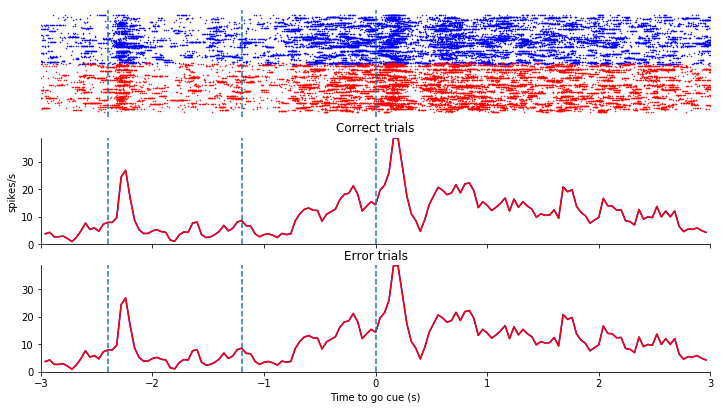

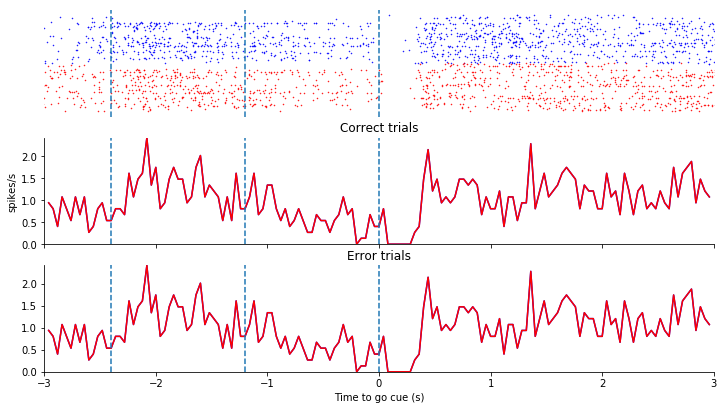

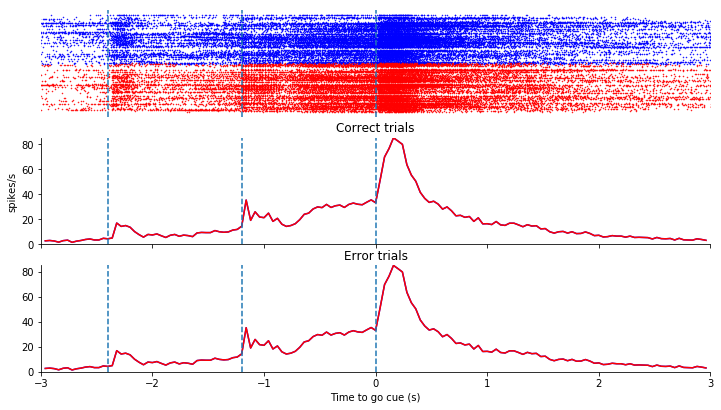

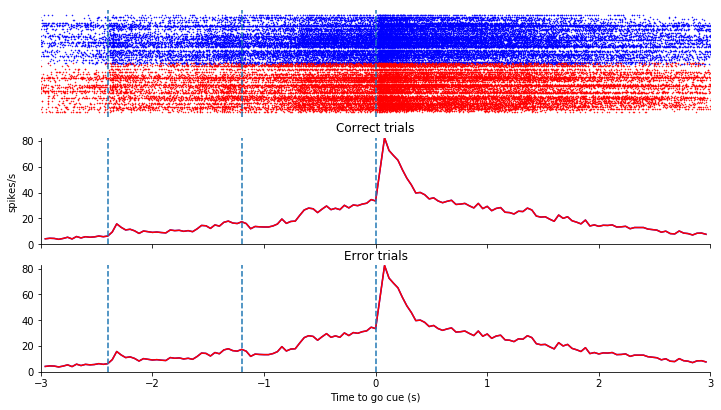

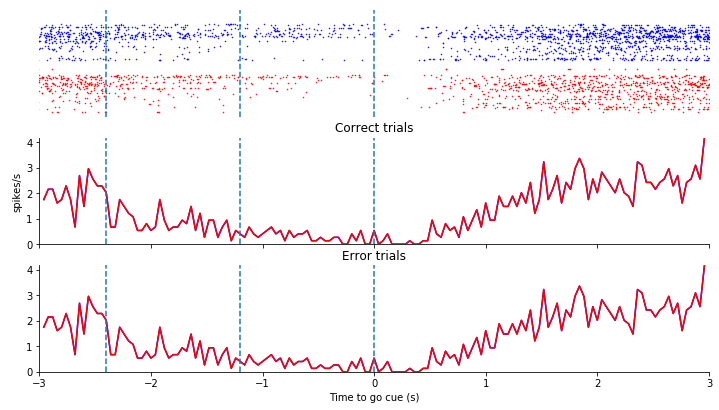

In [12]:
for u in ipsi_hit_psth_units:
    plot.unit_psth(u)